# Сравнение средних
![alt text](https://miro.medium.com/max/1400/0*lu4eTYjfc-Gs7U9b.png)


In [1]:
pip install arviz -U

Requirement already up-to-date: arviz in /usr/local/lib/python3.6/dist-packages (0.7.0)


In [2]:
pip install pymc3 -U

Requirement already up-to-date: pymc3 in /usr/local/lib/python3.6/dist-packages (3.8)


## Модельные данные (сравнение двух групп)

In [3]:
import numpy as np
from scipy import stats
import pandas as pd
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats.api as sms
%matplotlib inline
sns.set_style('whitegrid')
plt.rcParams["figure.figsize"] = (6,3)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
import warnings
warnings.filterwarnings('ignore')

In [0]:
import requests
import io

In [6]:
csv = requests.get(url="https://raw.githubusercontent.com/Opensourcefordatascience/Data-sets/master/difficile.csv")
csv.content

b'person,dose,libido\r\n1,1,3\r\n2,1,2\r\n3,1,1\r\n4,1,1\r\n5,1,4\r\n6,2,5\r\n7,2,2\r\n8,2,4\r\n9,2,2\r\n10,2,3\r\n11,3,7\r\n12,3,4\r\n13,3,5\r\n14,3,3\r\n15,3,6\r\n'

In [7]:
libido = pd.read_csv(io.StringIO(csv.content.decode('utf-8')), index_col=0)
libido

,dose,libido
person,,
1,1,3
2,1,2
3,1,1
4,1,1
5,1,4
6,2,5
7,2,2
8,2,4
9,2,2


## Сравнение двух средних
Посмотрим как будут работать методы на искуственных данных. Для этого сгенерируем выборку с заданными средними и дисперсией.
При проведении тестов на сравнение средних с помощью тестов делается важное предположение про постоянное среднее и дисперсию. 
В функции, генерирующей данные, есть возможность сделать дисперсию разной, но стационарной и задать как случайный процесс. В тетрадке приведен пример для случая с постоянной дисперсией. Посмотрите, что будет в других случаях самостоятельно


In [0]:
def generate_groups(means = [2,5], sigmas = [1,1], var_sigma = False, size = 10):
    """
    Artificial data for group comparing testing, sampled from normal distribution 
    
    Args:
        means (list of floats): list of predefined means, length equal to number of groups
        sigmas (list of floats): list of predefined sigmas, length equal to number of groups
    
    Return: 
        data(DataFrame): data frame with the data
    
    """
    if var_sigma:
        data = np.concatenate([ stats.norm.rvs(loc = loc, scale = abs(stats.norm.rvs(loc = scale, scale = 1)), size = size) for loc,scale in zip(means,sigmas)])
    else:
        data = np.concatenate([ stats.norm.rvs(loc = loc, scale = scale, size = size) for loc,scale in zip(means,sigmas)])
 
    groups = np.concatenate([[f'group{i}']*size for i in range(len(means))])
    df = pd.DataFrame(dict(value = data, group = groups))
    df['group_id'] = pd.Categorical(df['group']).codes
    return df

In [8]:
means = list(libido.groupby('dose').libido.mean())
means

[2.2, 3.2, 5.0]

In [9]:
sigmas = list(libido.groupby('dose').libido.std())
sigmas

[1.3038404810405297, 1.3038404810405297, 1.5811388300841898]

,value,group,group_id
114,6.629384,group2,2
93,1.149131,group1,1
76,4.185468,group1,1
1,2.620290,group0,0
83,2.214092,group1,1


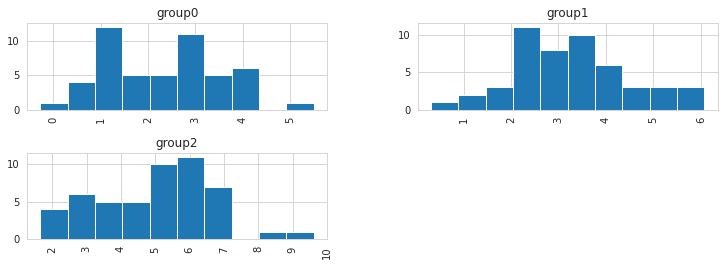

In [0]:
df = generate_groups(means, sigmas, var_sigma = False, size = 50)
df.hist('value', by='group', figsize=(12, 4));
df.sample(5)

In [12]:
libido[libido.dose==0].libido.values

array([], dtype=int64)

In [10]:
cm = sms.CompareMeans(sms.DescrStatsW(libido[libido.dose==1]['libido'].values), sms.DescrStatsW(libido[libido.dose==2]['libido'].values))
cm.summary()

,coef,std err,t,P>|t|,[0.025,0.975]
subset #1,-1.0000,0.825,-1.213,0.260,-2.902,0.902


### Добавляем кодированные группы по дозе

In [11]:
libido['group_id'] = libido['dose'] - 1
libido

,dose,libido,group_id
person,,,
1,1,3,0
2,1,2,0
3,1,1,0
4,1,1,0
5,1,4,0
6,2,5,1
7,2,2,1
8,2,4,1
9,2,2,1


In [12]:
libido['value'] = libido['libido']
libido

,dose,libido,group_id,value
person,,,,
1,1,3,0,3
2,1,2,0,2
3,1,1,0,1
4,1,1,0,1
5,1,4,0,4
6,2,5,1,5
7,2,2,1,2
8,2,4,1,4
9,2,2,1,2


как читать эту табличку?
### ANOVA  
Никто нам не мешает сделать anova и для случая с двумя переменным, зачем?

In [0]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

In [14]:
results = ols('libido ~ C(dose)', data=libido).fit()
print(results.summary())
aov_table = sm.stats.anova_lm(results, typ=2)
print(aov_table)
print(stats.levene(libido[libido.group_id==0]['value'], libido[libido.group_id==2]['value']))
print(stats.shapiro(results.resid))

                            OLS Regression Results                            
Dep. Variable:                 libido   R-squared:                       0.460
Model:                            OLS   Adj. R-squared:                  0.370
Method:                 Least Squares   F-statistic:                     5.119
Date:                Fri, 17 Apr 2020   Prob (F-statistic):             0.0247
Time:                        07:38:19   Log-Likelihood:                -24.683
No. Observations:                  15   AIC:                             55.37
Df Residuals:                      12   BIC:                             57.49
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        2.2000      0.627      3.508   

## Симуляция с помощью pymc 

повторим модель вот отсюда https://docs.pymc.io/notebooks/BEST.html

Для 2 групп 0 и 1 (доза 1 и 2):

In [15]:
mu = libido[libido['group_id'] != 2].libido.mean()
mu_std = libido[libido['group_id'] != 2].libido.std() * 2
sigma_low = 0.5
sigma_high = 5

with pm.Model() as model:
    group1_mean = pm.Normal('group1_mean', mu, sd=mu_std)
    group2_mean = pm.Normal('group2_mean', mu, sd=mu_std)
    group1_std = pm.Uniform('group1_std', lower=sigma_low, upper=sigma_high)
    group2_std = pm.Uniform('group2_std', lower=sigma_low, upper=sigma_high)
    ν = pm.Exponential('ν_minus_one', 1/29.) + 1
    lam_1 = group1_std**-2
    lam_2 = group2_std**-2
    diff_of_means = pm.Deterministic('difference of means', group1_mean - group2_mean)
    diff_of_stds = pm.Deterministic('difference of stds', group1_std - group2_std)
    effect_size = pm.Deterministic('effect size',
                                   diff_of_means / np.sqrt((group1_std**2 + group2_std**2) / 2))

    group1 = pm.StudentT('group1', nu=ν, mu=group1_mean, lam=lam_1, observed=libido[libido.dose==1]['libido'])
    group2 = pm.StudentT('group2', nu=ν, mu=group2_mean, lam=lam_2, observed=libido[libido.dose==2]['libido'])
    
    trace = pm.sample(2000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [ν_minus_one, group2_std, group1_std, group2_mean, group1_mean]
Sampling chain 1, 0 divergences: 100%|██████████| 3000/3000 [00:04<00:00, 749.99it/s]


На будущее: грузится долго, лучше сразу перейти к симуляции с 3 группами

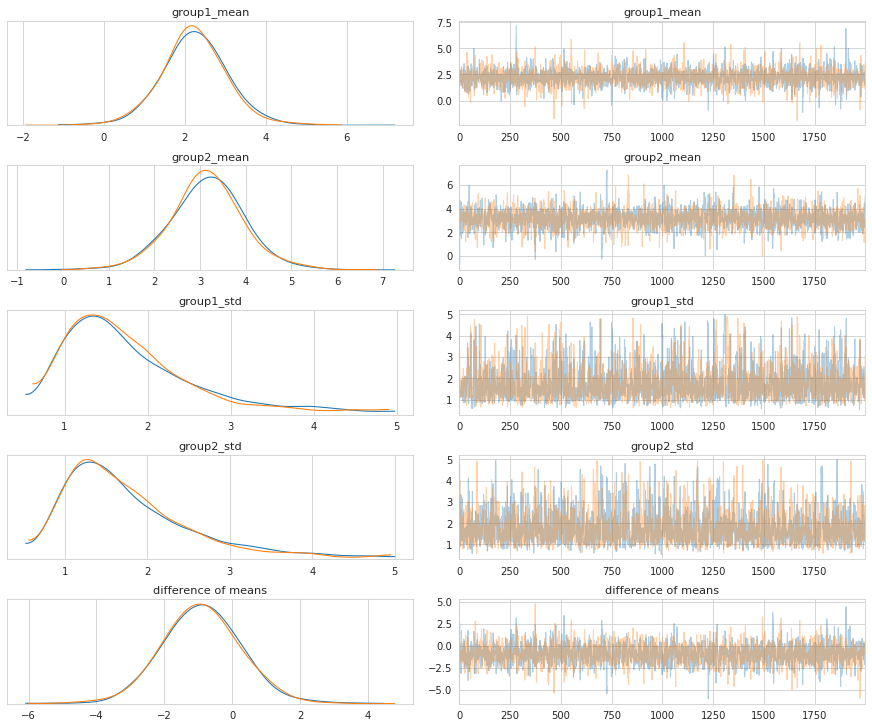

In [16]:
varnames = ['group1_mean','group2_mean', 'group1_std', 'group2_std', 'difference of means']
az.plot_trace(trace, varnames);

In [17]:
az.summary(trace, varnames, credible_interval=.95).round(3)

,mean,sd,hpd_2.5%,hpd_97.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
group1_mean,2.224,0.824,0.472,3.732,0.016,0.012,2720.0,2416.0,2842.0,2216.0,1.0
group2_mean,3.146,0.809,1.641,4.871,0.017,0.012,2316.0,2244.0,2496.0,2075.0,1.0
group1_std,1.800,0.821,0.617,3.567,0.020,0.015,1719.0,1434.0,2234.0,1525.0,1.0
group2_std,1.782,0.797,0.695,3.546,0.019,0.014,1839.0,1582.0,2344.0,1715.0,1.0
difference of means,-0.922,1.154,-3.168,1.252,0.023,0.017,2600.0,2212.0,2677.0,2558.0,1.0


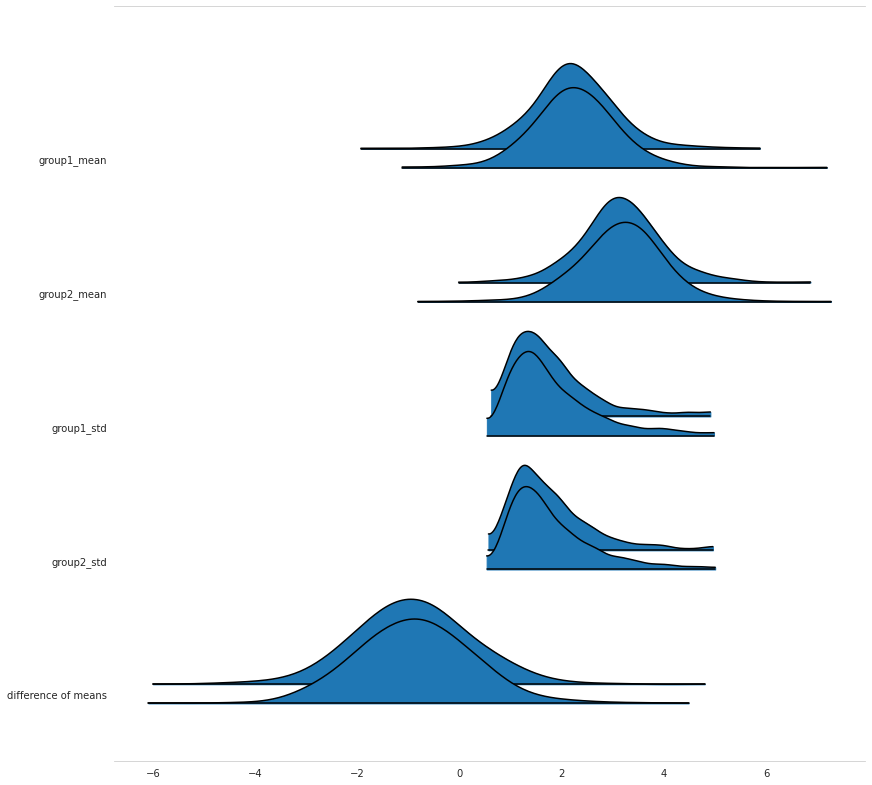

In [18]:
az.plot_forest(trace, var_names=varnames, kind = 'ridgeplot');

## То же самое, но сделаем это красиво и покороче

In [19]:
with pm.Model() as model_short:
 
    mean = pm.Normal('mean', mu=libido.libido.mean(), sd=2*libido.value.std(),  shape=(3,))
    #sd = pm.HalfCauchy('sd', beta=50, shape=(2,))
    sd = pm.Uniform('sigma', lower=0 , upper= 5, shape=(3,))
    # Define the nuisance parameter nu for the T distribution
    nu = pm.Exponential('nu', lam=1/29., shape=(3,)) + 1
    
    # Define the likelihood.
    like = pm.StudentT('likelihood', 
                       nu=nu[libido['group_id']],
                       mu=mean[libido['group_id']], 
                       sd=sd[libido['group_id']], 
                       observed=libido['value'])
    trace_short = pm.sample(2000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [nu, sigma, mean]
Sampling chain 1, 0 divergences: 100%|██████████| 3000/3000 [00:05<00:00, 549.54it/s]


In [20]:
az.summary(trace_short)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mean[0],2.287,0.898,0.690,4.022,0.018,0.015,2459.0,1693.0,2910.0,1587.0,1.0
mean[1],3.206,0.861,1.602,4.800,0.019,0.013,2149.0,2074.0,2386.0,1968.0,1.0
mean[2],4.858,1.007,2.838,6.635,0.018,0.013,2972.0,2972.0,3396.0,1609.0,1.0
sigma[0],1.822,0.825,0.632,3.433,0.021,0.017,1473.0,1216.0,2033.0,1338.0,1.0
sigma[1],1.804,0.811,0.626,3.459,0.026,0.019,998.0,881.0,1393.0,1053.0,1.0
sigma[2],2.103,0.874,0.794,3.845,0.021,0.016,1749.0,1467.0,2247.0,1440.0,1.0
nu[0],31.349,30.427,0.024,85.361,0.496,0.369,3759.0,3409.0,3094.0,2052.0,1.0
nu[1],30.445,28.524,0.013,82.193,0.463,0.377,3792.0,2868.0,3020.0,2010.0,1.0
nu[2],31.128,30.752,0.002,85.458,0.441,0.364,4867.0,3573.0,3910.0,2185.0,1.0


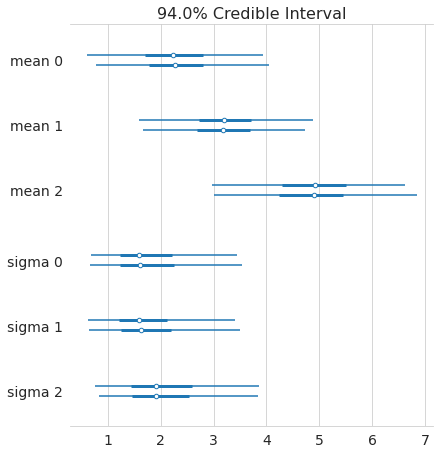

In [21]:
az.plot_forest(trace_short, var_names = ['~nu'] );

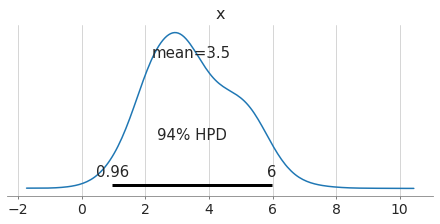

In [22]:
az.plot_posterior(trace_short['mean']);

добавим размер эффекта, будем использовать CohenD, разница между средними нормированная на усредненное стандартное отклонение, аналог z статистики, но для двух групп

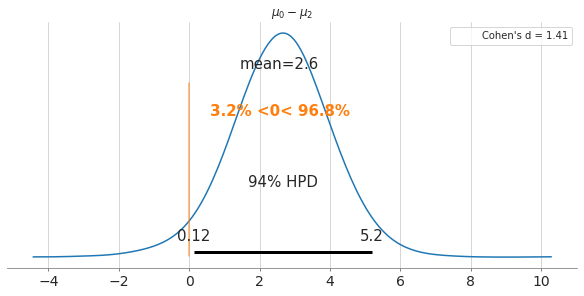

In [24]:
means_diff = trace_short['mean'][:, 2] - trace_short['mean'][:, 0]
d_cohen = (means_diff / np.sqrt((trace_short['sigma'][:, 0]**2 +
trace_short['sigma'][:, 2]**2) / 2)).mean()
_, ax = plt.subplots(1, 1, figsize=(8, 4), constrained_layout=True)
az.plot_posterior(means_diff, ref_val=0, ax=ax)
ax.set_title(f'$\mu_{0}-\mu_{2}$')
ax.plot(0, label=f"Cohen's d = {d_cohen:.2f}",alpha=0)
ax.legend();

Для групп 0 и 2 видим, что среднее уже заметно отличается

## Модельные данные (сравнение нескольких групп)
посмотрим как можно сравнивать между собой несколько групп. Тут почти ничего не надо менять в байесовом анализе, можно добавить добверительных интервалов после ANOVA. Вы можете поэкспериментировать с разными настройками. 
Давайте попробуем сравнить между собой группы с достаточно близкими средними

,value,group,group_id
84,3.964451,group1,1
42,2.543917,group0,0
141,4.753069,group2,2
112,2.687793,group2,2
185,2.448262,group3,3


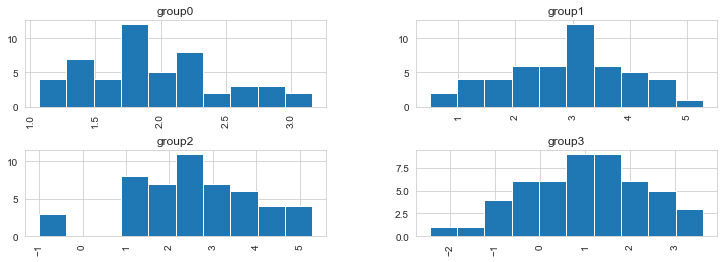

In [0]:
means = [2, 3, 2.5, 1.5]
sigmas = [0.5, 1, 1.5, 1.5]
df = generate_groups(means, sigmas, var_sigma = False, size = 50)
df.hist('value', by='group', figsize=(12, 4));
df.sample(5)

In [25]:
results = ols('value ~ C(group_id)', data=libido).fit()
print(results.summary())
aov_table = sm.stats.anova_lm(results, typ=2)
print(aov_table)
print(stats.levene(libido[libido.group_id==0]['value'], libido[libido.group_id==2]['value']))
print(stats.shapiro(results.resid))
mc = MultiComparison(libido['value'], libido['group_id'])
mc_results = mc.tukeyhsd()
print(f"истинные средние по группам {means}")
print(mc_results)

                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.460
Model:                            OLS   Adj. R-squared:                  0.370
Method:                 Least Squares   F-statistic:                     5.119
Date:                Fri, 17 Apr 2020   Prob (F-statistic):             0.0247
Time:                        07:47:54   Log-Likelihood:                -24.683
No. Observations:                  15   AIC:                             55.37
Df Residuals:                      12   BIC:                             57.49
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            2.2000      0.627  

что значат все эти цифры????

Проведённый анализ предлагает нам отбросить нулевую гипотезу о равенстве средних только между группами 0 и 2

In [26]:
n_groups = len(means)
with pm.Model() as model_group:
 
    mean = pm.Normal('mean', mu=libido.value.mean(), sd=2*libido.value.std(),  shape=(n_groups,))
    #sd = pm.HalfCauchy('sd', beta=50, shape=(n_groups,))
    sd = pm.Uniform('sigma', lower=0 , upper = 5, shape=(n_groups,))
    # Define the nuisance parameter nu for the T distribution
    nu = pm.Exponential('nu', lam=1/29., shape=(n_groups,)) + 1
    
    # Define the likelihood.
    like = pm.StudentT('likelihood', 
                       nu=nu[libido['group_id']],
                       mu=mean[libido['group_id']], 
                       sd=sd[libido['group_id']], 
                       observed=libido['value'])
    trace_group = pm.sample(2000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [nu, sigma, mean]
Sampling chain 1, 0 divergences: 100%|██████████| 3000/3000 [00:05<00:00, 555.13it/s]


In [27]:
az.summary(trace_group,  var_names = ['~nu'])

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mean[0],2.264,0.834,0.657,3.849,0.019,0.014,1903.0,1669.0,2066.0,1622.0,1.0
mean[1],3.183,0.849,1.503,4.780,0.016,0.011,2770.0,2770.0,3107.0,1689.0,1.0
mean[2],4.895,0.984,3.016,6.703,0.020,0.014,2487.0,2472.0,2695.0,2059.0,1.0
sigma[0],1.814,0.821,0.660,3.449,0.024,0.019,1160.0,941.0,1681.0,877.0,1.0
sigma[1],1.818,0.820,0.597,3.343,0.023,0.018,1284.0,1030.0,1818.0,1276.0,1.0
sigma[2],2.095,0.849,0.792,3.798,0.021,0.016,1636.0,1374.0,2251.0,1565.0,1.0


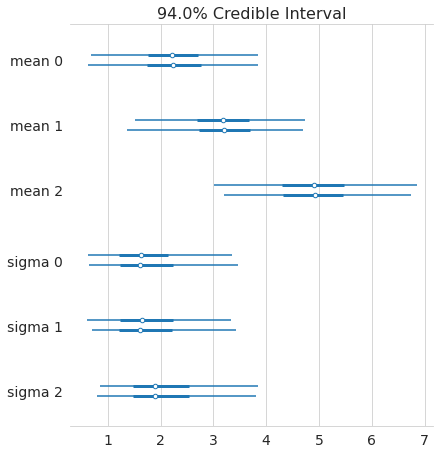

In [28]:
az.plot_forest(trace_group, var_names = ['~nu'] );

In [31]:
comparisons = [(i, j) for i in range(n_groups) for j in range(i+1, n_groups)]
comparisons

[(0, 1), (0, 2), (1, 2)]

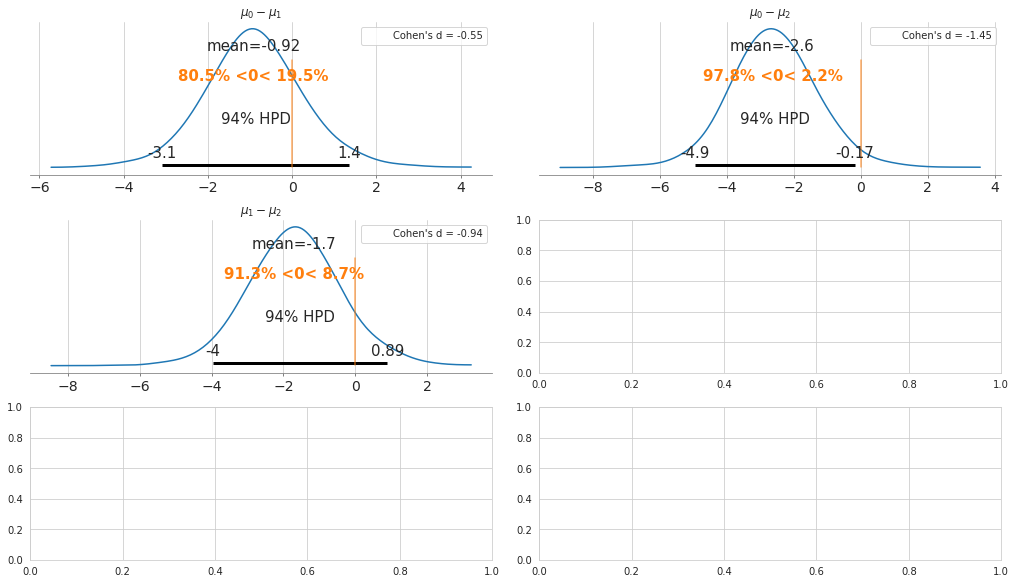

In [32]:
def plot_diff_effects(n_groups, trace_group):
    comparisons = [(i, j) for i in range(n_groups) for j in range(i+1, n_groups)]
    pos = [(k, l) for k in range(n_groups-1) for l in (0, 1)]
    _, ax = plt.subplots(len(comparisons), 2, figsize=(14, 8), constrained_layout=True)
    for (i, j), (k, l) in zip(comparisons, pos):
        means_diff = trace_group['mean'][:, i] - trace_group['mean'][:, j]
        d_cohen = (means_diff / np.sqrt((trace_group['sigma'][:, i]**2 +
            trace_group['sigma'][:, j]**2) / 2)).mean()
        az.plot_posterior(means_diff, ref_val=0, ax=ax[k, l])
        ax[k, l].set_title(f'$\mu_{i}-\mu_{j}$')
        ax[k, l].plot(0, label=f"Cohen's d = {d_cohen:.2f}",alpha=0)
        ax[k, l].legend()
plot_diff_effects(n_groups, trace_group)        

И снова убеждаемся, что только в случае с группами 0 и 2 (дозами 1 и 3) мы можем отвергнуть гипотезу о равенстве средних, и это если наша HPD = 94%.